In [41]:
import sys
sys.path.append('../src')
import importlib

from agent import Agent
from conversation import run_conversation

# import feature_evaluator
# importlib.reload(feature_evaluator)

from feature_evaluator import feature_rater

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocess as mp
import pickle

In [48]:
key = "happy"

def run_single_conversation(_):
    """Function to generate one conversation and rate it."""
    agent1 = Agent()
    agent1.load_system_message(f"# Background: Two people, you and another person, met at church. \n # Persona: You are {key}.")

    agent2 = Agent()
    agent2.load_system_message("# Background: Two people, you and another person, met at church.")

    conversation = run_conversation([], agent1, agent2, n_rounds=10)

    rating_instruction = f"Given a message, rate {key} from 1(no {key}) to 5(extreme {key})."

    agent1_rating = [feature_rater(rating_instruction, x['content']) for x in conversation if x['role'] == 'user']
    agent2_rating = [feature_rater(rating_instruction, x['content']) for x in conversation if x['role'] == 'assistant']

    return agent1_rating, agent2_rating, conversation

if __name__ == "__main__":
    num_processes = min(mp.cpu_count(), 10)  # Use all available CPU cores
    with mp.Pool(num_processes) as pool:
        results = pool.map(run_single_conversation, range(10))  # Run 10 conversations in parallel

    # Unpacking results
    agent1_ratings, agent2_ratings, conversations = zip(*results)

    # Saving results to files
    with open(f'../results/r1_{key}_simple.pkl', 'wb') as f:
        pickle.dump(agent1_ratings, f)

    with open(f'../results/r2_{key}_simple.pkl', 'wb') as f:
        pickle.dump(agent2_ratings, f)

    with open(f'../results/c_{key}_simple.pkl', 'wb') as f:
        pickle.dump(conversations, f)

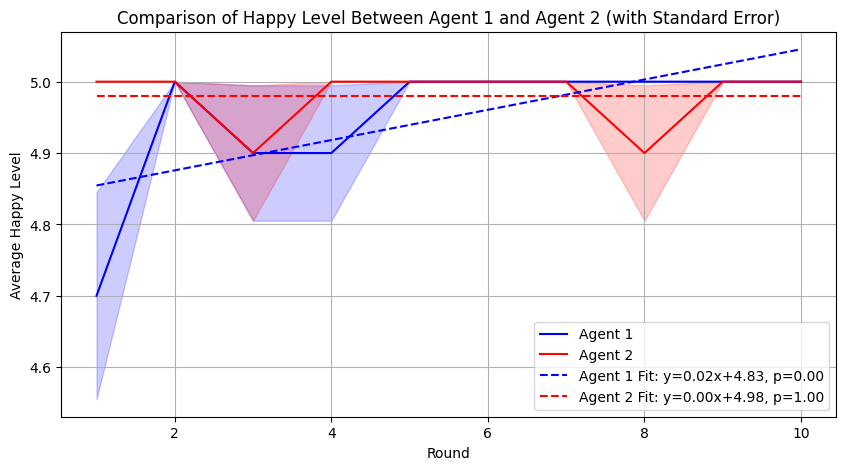

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

agent1_ratings = np.array(agent1_ratings)
agent2_ratings = np.array(agent2_ratings)

# Compute mean and standard error (SE)
agent1_mean = np.mean(agent1_ratings, axis=0)
agent1_se = np.std(agent1_ratings, axis=0) / np.sqrt(agent1_ratings.shape[0])

agent2_mean = np.mean(agent2_ratings, axis=0)
agent2_se = np.std(agent2_ratings, axis=0) / np.sqrt(agent2_ratings.shape[0])

rounds = np.arange(1, len(agent1_mean) + 1)

# Flatten data for regression
agent1_x = np.array(list(rounds)*agent1_ratings.shape[0])
agent1_y = agent1_ratings.flatten()

agent2_x = np.array(list(rounds)*agent2_ratings.shape[0])
agent2_y = agent2_ratings.flatten()

# Perform linear regression
agent1_slope, agent1_intercept, agent1_r, agent1_p, _ = stats.linregress(agent1_x, agent1_y)
agent2_slope, agent2_intercept, agent2_r, agent2_p, _ = stats.linregress(agent2_x, agent2_y)

# Create regression lines
agent1_fit = agent1_slope * rounds + agent1_intercept
agent2_fit = agent2_slope * rounds + agent2_intercept

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(rounds, agent1_mean, label="Agent 1", color='blue')
plt.fill_between(rounds, agent1_mean - agent1_se, agent1_mean + agent1_se, color='blue', alpha=0.2)

plt.plot(rounds, agent2_mean, label="Agent 2", color='red')
plt.fill_between(rounds, agent2_mean - agent2_se, agent2_mean + agent2_se, color='red', alpha=0.2)

# Plot regression lines
plt.plot(rounds, agent1_fit, '--', color='blue', label=f"Agent 1 Fit: y={agent1_slope:.2f}x+{agent1_intercept:.2f}, p={agent1_p:.2f}")
plt.plot(rounds, agent2_fit, '--', color='red', label=f"Agent 2 Fit: y={agent2_slope:.2f}x+{agent2_intercept:.2f}, p={agent2_p:.2f}")

plt.xlabel("Round")
plt.ylabel(f"Average {key[0].upper()+key[1:]} Level")
plt.title(f"Comparison of {key[0].upper()+key[1:]} Level Between Agent 1 and Agent 2 (with Standard Error)")
plt.legend()
plt.grid(True)

# Show plot
plt.show()